# Analysis

**Problem Statement:**

There are so many apps on app store, some paid some free; I want to validate few of these scenarios:
 - What makes an app successfull, what is that metric
 - What other metrics are available?
 - Is there correlation between this success metric and other metrics
 - What does the clusters look like if we try to cluster them
 
This might sound vague at the moment but essentially I want to analyse apps in app store;

### Task 1: In this notebook we would essentially be dealing with pre processing of the data to make it more convenient to use;

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.set_palette("Set1", 8, .75)

In [2]:
df = pd.read_csv("../dataset/data.csv")

In [3]:
# list of all columns
df.columns

Index(['kind', 'features', 'advisories', 'trackCensoredName', 'fileSizeBytes',
       'contentAdvisoryRating', 'genreIds', 'currentVersionReleaseDate',
       'currency', 'wrapperType', 'version', 'artistName', 'artistId',
       'genres', 'price', 'description', 'trackName', 'bundleId',
       'isVppDeviceBasedLicensingEnabled', 'primaryGenreName', 'releaseDate',
       'minimumOsVersion', 'formattedPrice', 'primaryGenreId',
       'averageUserRating', 'userRatingCount', 'avgUserRatingCV',
       'userRatingCountCV', 'sellerUrl', 'releaseNotes'],
      dtype='object')

In [4]:
print ("No of rows in dataset: %d, No of columns: %d" %  (df.shape[0], df.shape[1]))

No of rows in dataset: 325426, No of columns: 30


**Note that:** `trackName` property is the name of application and `bundleId` is the unique name; we can use these bost as unique properties;


In [5]:
# let's define a new dataframe where we will store more processed information
data = pd.DataFrame()
data['bundleId'] = df['bundleId']
data['trackName'] = df['trackName']

## Pre processing

### (1) Kind

In [6]:
df.kind.value_counts()

software    325426
Name: kind, dtype: int64

**Summary**: all data in the list is of same kind hence we will ignore this property
### (2) features

In [7]:
df.features.value_counts(normalize=True) * 100

["iosUniversal"]    68.857129
[]                  31.142871
Name: features, dtype: float64

**Summary:** since there are only two possible outcomes I'll conver this to a column called `isUniversal`

In [8]:
def getIsUniversal(x):
    if x == '[]':
        return False
    return True

data['IsUniversal'] = df['features'].apply(lambda x: getIsUniversal(x))

data.head(10)

,bundleId,trackName,IsUniversal
0,com.aaa.iphone.discounts,AAA Mobile,True
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True
3,com.BulletParty.BunboGames,AAA Bullet Party - Online first person shooter...,True
4,com.fmapp2010.ISearchFree,iSheacher,False
5,com.onteca.civilwarlite,AAA American Civil War Cannon Shooter : Defend...,True
6,com.appynation.powertoolsfree,Draw with Powertools FX Free,True
7,com.1361447304.4691361447304,AAA+ Foundr - Entrepreneur Magazine for a Startup,True
8,com.1443792976.11461443792976,AAA+ Swimsuits & Sports Magazine App For Men,True
9,com.AnjaneyaApps.AAA1024Free,AAA 1024 Puzzle - cool math board game,True


### (3) advisories

In [9]:
# df.advisories.value_counts()
# TODO: this is a categorical data and one row can have one or more of these; Think of how to deal with this
# but this could be an important data after all

advisories = {}
for advisoriesString in df.advisories.values:
    ads = json.loads(advisoriesString)
    for a in ads:
        if a not in advisories:
            advisories[a] = 0
        advisories[a] = advisories[a] + 1

In [10]:
adf = pd.DataFrame([[k,v] for k,v in advisories.items()], columns=['advisory', 'count'])
adf.head(10)

,advisory,count
0,Infrequent/Mild Simulated Gambling,3458
1,Infrequent/Mild Realistic Violence,9387
2,"Infrequent/Mild Alcohol, Tobacco, or Drug Use ...",13828
3,Frequent/Intense Cartoon or Fantasy Violence,4288
4,Frequent/Intense Medical/Treatment Information,3992
5,Infrequent/Mild Medical/Treatment Information,9460
6,Infrequent/Mild Mature/Suggestive Themes,14720
7,Frequent/Intense Horror/Fear Themes,1368
8,Frequent/Intense Simulated Gambling,4912
9,Unrestricted Web Access,17518


In [11]:
adf = adf.sort_values(["count"], axis=0, ascending=False)

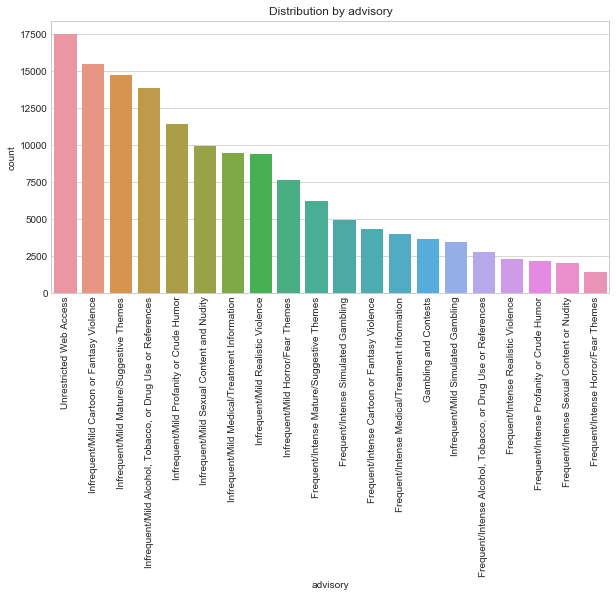

In [12]:
plt.figure(figsize=(10, 5))
fx = sns.barplot(x='advisory', y='count', data=adf)
fx.set_xticklabels(rotation=90, labels=adf['advisory'])
plt.title("Distribution by advisory")

In [13]:
data["advisories"] = df.advisories

### (4) trackCensoredName

This seem to be very similar to the name of the track itself, let's see the no of rows where these values differ

In [14]:
print (df.loc[df['trackCensoredName'] != df['trackName']].shape)

df.loc[df['trackCensoredName'] != df['trackName']][['trackCensoredName', 'trackName']]

(4, 30)


,trackCensoredName,trackName
77518,F*g Garanti - Kvalitetsstemplet,Fag Garanti - Kvalitetsstemplet
138646,F*G SmartCheck,FAG SmartCheck
177041,Chin'Chic et les P't**s Malins,Chin'Chic et les P'tits Malins
299371,Bull S**t - Reloaded,Bull Shit - Reloaded


**Summary:**: only four rows with trackCensoredName differing from trackName so this features is useless for now

### (5) fileSizeBytes
This seem to be an interesting property let's see

Average file size in MD: 58.10 
Median file size in MD: 29.83 


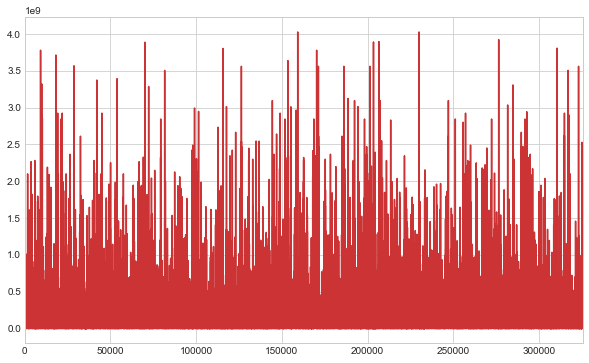

In [15]:
meanSize = df.fileSizeBytes.mean()
medianSize = df.fileSizeBytes.median()


print ("Average file size in MD: %0.2f " % (meanSize / (1024 * 1024)))
print ("Median file size in MD: %0.2f " % (medianSize / (1024 * 1024)))

df.fileSizeBytes.plot(figsize=(10,6))

In [16]:
data['fileSizeInMB'] = df['fileSizeBytes'].apply(lambda x: x / (1024 * 1024))
data.head(10)

,bundleId,trackName,IsUniversal,advisories,fileSizeInMB
0,com.aaa.iphone.discounts,AAA Mobile,True,[],153.721680
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False,"[""Infrequent/Mild Mature/Suggestive Themes""]",29.033732
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True,"[""Infrequent/Mild Realistic Violence"", ""Infreq...",174.367188
3,com.BulletParty.BunboGames,AAA Bullet Party - Online first person shooter...,True,"[""Frequent/Intense Mature/Suggestive Themes"", ...",1182.394531
4,com.fmapp2010.ISearchFree,iSheacher,False,"[""Infrequent/Mild Alcohol, Tobacco, or Drug Us...",1.434688
5,com.onteca.civilwarlite,AAA American Civil War Cannon Shooter : Defend...,True,"[""Infrequent/Mild Cartoon or Fantasy Violence""]",107.042969
6,com.appynation.powertoolsfree,Draw with Powertools FX Free,True,[],56.867188
7,com.1361447304.4691361447304,AAA+ Foundr - Entrepreneur Magazine for a Startup,True,[],32.477539
8,com.1443792976.11461443792976,AAA+ Swimsuits & Sports Magazine App For Men,True,"[""Infrequent/Mild Mature/Suggestive Themes"", ""...",37.444336
9,com.AnjaneyaApps.AAA1024Free,AAA 1024 Puzzle - cool math board game,True,[],13.113281


### (6) contentAdvisoryRating

4+               247982
17+               33675
12+               31243
9+                12514
Not yet rated        12
Name: contentAdvisoryRating, dtype: int64

Normalized distribution %
4+               76.202270
17+              10.347975
12+               9.600647
9+                3.845421
Not yet rated     0.003687
Name: contentAdvisoryRating, dtype: float64


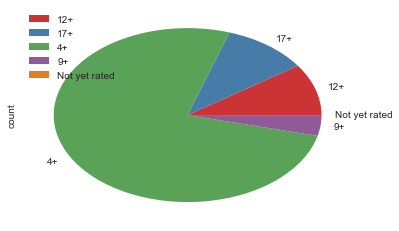

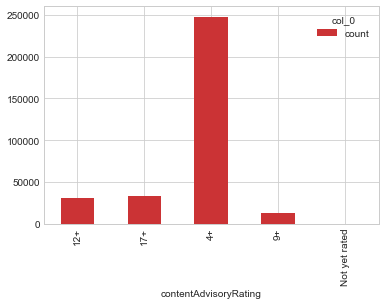

In [17]:
print (df.contentAdvisoryRating.value_counts())
print ()
print ("Normalized distribution %")
print (df.contentAdvisoryRating.value_counts(normalize =True) * 100)

_ct = pd.crosstab(df.contentAdvisoryRating, "count")
_ct.plot(kind="pie", subplots=True)

_ct.plot(kind="bar")

In [18]:
data['contentAdvisoryRating'] = df['contentAdvisoryRating']

**Summary**: while nearly `75%` is `4+` rated apps other seem to have a meaning full distribution as well;
### (7) genreIds

This feature intutively seem to be highly correlated to `genres` property; So we shall rather look at that in place of this;

### (8) currentVersionReleaseDate
release date of current version; seems an interesting property which doens't need much preprocessing we will keep it as such;

In [19]:
data['currentVersionReleaseDate'] = df.currentVersionReleaseDate

### (9) currency

In [20]:
df.currency.value_counts()

USD    325426
Name: currency, dtype: int64

All values are USD hence we will ignore
### (10) wrapperType

In [21]:
df.wrapperType.value_counts()

software    325426
Name: wrapperType, dtype: int64

all values are software; hence we will ignore
### (11) version

In [22]:
df.version.value_counts().head(20)

1.0      61293
1.1      22754
1.2      13378
2.0       8446
1.3       7976
1.0.1     7412
1.4       5821
1.0.0     5286
1.0.2     4550
1.5       4132
2.1       3994
3.0       3225
1.0.3     2919
1.6       2897
2.2       2546
1.1.0     2397
1.1.1     2162
1.0.4     2040
1.7       1995
1.2.1     1780
Name: version, dtype: int64

**Summary**
 - This seem to be string like property which can have any value;
 We can maybe extract features like major version and subversions

In [23]:
def getMajorVersion(ver):
    return ver.split('.')[0]

def getMajorSubVersion(ver):
    splt = ver.split('.')
    if len(splt) >= 2:
        return ".".join(splt[0:2])
    return splt[0] +".0"

data['version'] = df['version'].apply(lambda x: getMajorVersion(x))
data['subversion'] = df['version'].apply(lambda x: getMajorSubVersion(x))

data[['bundleId', 'version', 'subversion']].head(10)

,bundleId,version,subversion
0,com.aaa.iphone.discounts,3,3.11
1,com.nextgenreality.gunclublite,1,1.7
2,com.mcgames.chaosstrike2,2,2.0
3,com.BulletParty.BunboGames,1,1.0
4,com.fmapp2010.ISearchFree,1,1.3
5,com.onteca.civilwarlite,4,4.1
6,com.appynation.powertoolsfree,2,2.7
7,com.1361447304.4691361447304,7,7.8
8,com.1443792976.11461443792976,7,7.8
9,com.AnjaneyaApps.AAA1024Free,1,1.2


### (12) artistName

In [24]:
print ("artists with max applications")
df.artistName.value_counts().head(20)

artists with max applications


CrowdCompass, Inc.                      1523
eChurch Apps                            1212
MINDBODY, Incorporated                  1008
Subsplash Inc                            997
DoubleDutch                              800
FMG Suite                                704
KitApps, Inc.                            612
SKOOLBAG PTY LTD                         575
ChowNow                                  463
Ketchapp                                 418
EventMobi                                414
Sharefaith                               398
AppsVision                               396
Magzter Inc.                             368
Tapps Tecnologia da Informação Ltda.     316
Flytomap                                 261
Guidebook Inc                            258
Narvii Inc.                              244
Nobex Technologies                       243
Big Fish Games, Inc                      234
Name: artistName, dtype: int64

In [25]:
data['artist'] = df['artistName']

### (13) artistId:
might is highly correlated to artistName and hence will ignore

### (14) genres
This is one of very important property; Let's do some analysis here

In [26]:
import json
genres = {}
for genreString in df.genres.values:
    gs = json.loads(genreString)
    for g in gs:
        if g not in genres:
            genres[g] = 0
        genres[g] = genres[g] + 1

In [27]:
gdf = pd.DataFrame([[k,v] for k,v in genres.items()], columns=['genre', 'count'])
gdf.head(10)

,genre,count
0,Business,43091
1,Racing,5894
2,Games,79645
3,Food & Drink,9041
4,Eating & Drinking,86
5,Finance,15379
6,Celebrations,204
7,People,234
8,Art,213
9,Sports,20509


In [28]:
gs = gdf.sort_values(["count"], axis=0, ascending=False)

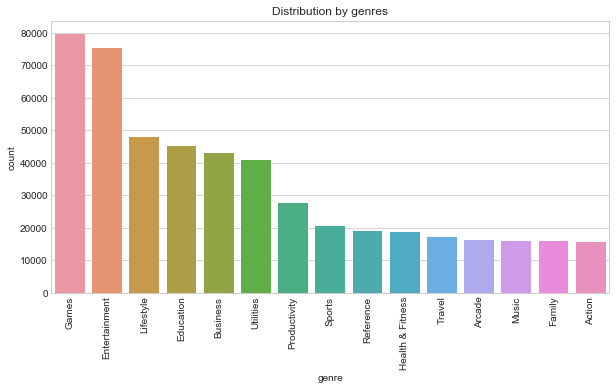

In [29]:
plt.figure(figsize=(10, 5))
fx = sns.barplot(x='genre', y='count', data=gs.head(15))
fx.set_xticklabels(rotation=90, labels=gs['genre'])
plt.title("Distribution by genres")

In [30]:
data['genres'] = df['genres']
data.head(10)

,bundleId,trackName,IsUniversal,advisories,fileSizeInMB,contentAdvisoryRating,currentVersionReleaseDate,version,subversion,artist,genres
0,com.aaa.iphone.discounts,AAA Mobile,True,[],153.721680,4+,2017-12-19T13:23:36Z,3,3.11,American Automobile Association,"[""Lifestyle"", ""Travel""]"
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False,"[""Infrequent/Mild Mature/Suggestive Themes""]",29.033732,9+,2009-11-07T02:12:31Z,1,1.7,Gun Club Studios,"[""Entertainment"", ""Games"", ""Simulation"", ""Acti..."
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True,"[""Infrequent/Mild Realistic Violence"", ""Infreq...",174.367188,12+,2016-06-13T17:52:01Z,2,2.0,Hasim Mert Corekci,"[""Games"", ""Arcade"", ""Action""]"
3,com.BulletParty.BunboGames,AAA Bullet Party - Online first person shooter...,True,"[""Frequent/Intense Mature/Suggestive Themes"", ...",1182.394531,17+,2015-04-22T15:01:15Z,1,1.0,Engin Yildiz,"[""Games"", ""Arcade"", ""Action""]"
4,com.fmapp2010.ISearchFree,iSheacher,False,"[""Infrequent/Mild Alcohol, Tobacco, or Drug Us...",1.434688,17+,2011-11-23T01:52:45Z,1,1.3,feng min,"[""Photo & Video"", ""Utilities""]"
5,com.onteca.civilwarlite,AAA American Civil War Cannon Shooter : Defend...,True,"[""Infrequent/Mild Cartoon or Fantasy Violence""]",107.042969,9+,2015-06-29T16:38:41Z,4,4.1,Onteca,"[""Games"", ""Entertainment"", ""Strategy"", ""Simula..."
6,com.appynation.powertoolsfree,Draw with Powertools FX Free,True,[],56.867188,4+,2016-01-12T23:42:31Z,2,2.7,Onteca,"[""Games"", ""Photo & Video"", ""Trivia"", ""Board""]"
7,com.1361447304.4691361447304,AAA+ Foundr - Entrepreneur Magazine for a Startup,True,[],32.477539,4+,2017-05-12T22:18:51Z,7,7.8,NHC PUBLISHING PTY. LTD,"[""Business"", ""Magazines & Newspapers""]"
8,com.1443792976.11461443792976,AAA+ Swimsuits & Sports Magazine App For Men,True,"[""Infrequent/Mild Mature/Suggestive Themes"", ""...",37.444336,17+,2017-02-14T21:57:51Z,7,7.8,azacreations,"[""Magazines & Newspapers"", ""Sports""]"
9,com.AnjaneyaApps.AAA1024Free,AAA 1024 Puzzle - cool math board game,True,[],13.113281,4+,2014-05-28T07:00:00Z,1,1.2,Bharat Bhushan,"[""Games"", ""Puzzle"", ""Entertainment"", ""Family""]"


### (15) Price
One of most important field

In [31]:
percentageFree = df[df.price == 0].shape[0] / df.shape[0] * 100

print ("%% Free: %0.3f %%" % percentageFree)

% Free: 89.438 %


In [32]:
data['price'] = df['price']

In [33]:
data.head(3)

,bundleId,trackName,IsUniversal,advisories,fileSizeInMB,contentAdvisoryRating,currentVersionReleaseDate,version,subversion,artist,genres,price
0,com.aaa.iphone.discounts,AAA Mobile,True,[],153.721680,4+,2017-12-19T13:23:36Z,3,3.11,American Automobile Association,"[""Lifestyle"", ""Travel""]",0.0
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False,"[""Infrequent/Mild Mature/Suggestive Themes""]",29.033732,9+,2009-11-07T02:12:31Z,1,1.7,Gun Club Studios,"[""Entertainment"", ""Games"", ""Simulation"", ""Acti...",0.0
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True,"[""Infrequent/Mild Realistic Violence"", ""Infreq...",174.367188,12+,2016-06-13T17:52:01Z,2,2.0,Hasim Mert Corekci,"[""Games"", ""Arcade"", ""Action""]",0.0


### (16) Description
This is a plain text field, will just copy it to new dataframe and use as text features later

In [34]:
data['description'] = df.description

### (17) isVppDeviceBasedLicensingEnabled
I don't totally know what this feature means (TODO);
99.2% sample have true value rest have false, but stills storing this to actual df

In [35]:
df.isVppDeviceBasedLicensingEnabled.value_counts(normalize=True) * 100

True     99.271109
False     0.728891
Name: isVppDeviceBasedLicensingEnabled, dtype: float64

In [36]:
data['isVppDeviceBasedLicensingEnabled'] = df.isVppDeviceBasedLicensingEnabled

### (17) primaryGenreName
This is an interesting feature

In [37]:
df.primaryGenreName.value_counts(normalize=True) * 100

Games                     21.963519
Business                   9.546256
Education                  8.949500
Lifestyle                  6.593819
Entertainment              6.125509
Utilities                  5.890740
Finance                    3.736026
Health & Fitness           3.681636
Productivity               3.395549
Travel                     3.312888
Sports                     2.950594
Music                      2.941068
Medical                    2.849496
Photo & Video              2.705070
Reference                  2.458009
Food & Drink               2.186672
Social Networking          2.159323
News                       2.155943
Shopping                   1.972184
Book                       1.813930
Navigation                 1.368360
Stickers                   0.721823
Weather                    0.445263
Magazines & Newspapers     0.076822
Name: primaryGenreName, dtype: float64

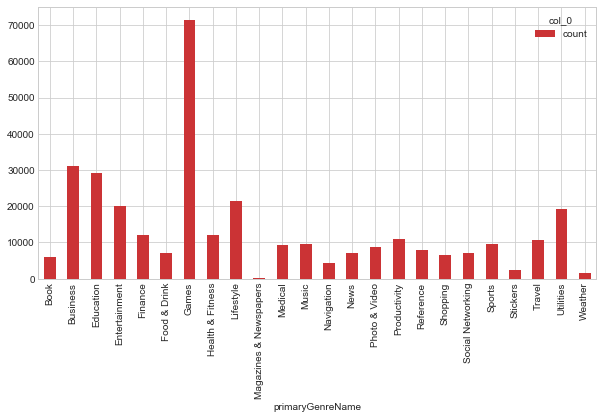

In [38]:
_ct = pd.crosstab(df.primaryGenreName, "count")
_ct.plot(kind='bar', figsize=(10, 5))

In [39]:
data['primaryGenreName'] = df.primaryGenreName

### (17) releaseDate
released date of app; This could be related to how old the app is

In [40]:
# data['releaseDate'] = df.releaseDate
from datetime import datetime
def getAgeInDays(datestring):
    return (datetime.now() - datetime.strptime(datestring, "%Y-%m-%dT%H:%M:%SZ")).days

data['releaseDate'] = df.releaseDate
data['ageInDays'] = df.releaseDate.apply(lambda x: getAgeInDays(x))

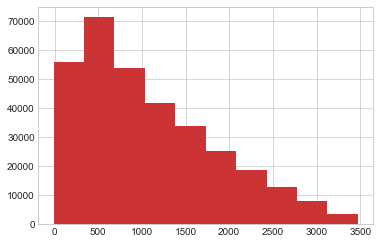

In [41]:
data['ageInDays'].hist()

### (18) minimumOsVersion
We will just keep the main version no for simplicity

In [42]:
def getMajorOSVersion(osver):
    return osver.split(".")[0]
data['minimumOsVersion'] = df.minimumOsVersion.apply(lambda x: getMajorOSVersion(x))

In [43]:
# % distribution
data['minimumOsVersion'].value_counts(normalize=True) * 100

8     31.688310
7     18.771088
6     17.206062
9     15.771327
5      5.356671
10     4.593364
4      4.281772
3      1.698082
11     0.434815
2      0.198509
Name: minimumOsVersion, dtype: float64

### (19) formattedPrice
Since we have price we will ignore this

### (20) primaryGenreId
Since we have string of primary Genre we will ignore this

### (21, 22) averageUserRating & avgUserRatingCV
This is another most important feature

In [44]:
# Actual
df.averageUserRating.value_counts(normalize=True) * 100

null    64.345197
4.5     11.909005
4.0      7.458839
3.5      4.804472
5.0      3.555647
3.0      3.420747
2.5      2.303750
2.0      1.363136
1.5      0.614272
1.0      0.224936
Name: averageUserRating, dtype: float64

In [45]:
# current version
df.avgUserRatingCV.value_counts(normalize=True) * 100

null    59.795775
5.0      9.968165
4.5      9.513069
4.0      6.126124
3.5      3.660433
3.0      3.488658
1.0      2.906344
2.5      1.931929
2.0      1.758925
1.5      0.850577
Name: avgUserRatingCV, dtype: float64

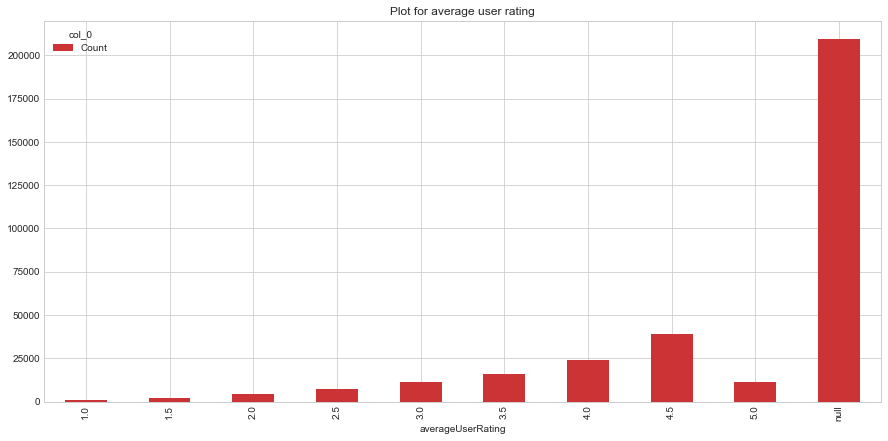

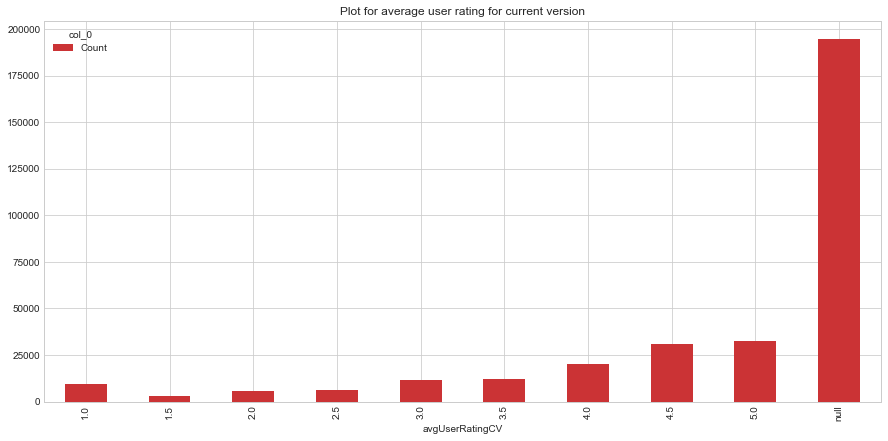

In [46]:
_ct = pd.crosstab(df.averageUserRating, "Count")
_ct.plot(kind='bar', figsize=(15, 7))
plt.title("Plot for average user rating")

_ct = pd.crosstab(df.avgUserRatingCV, "Count")
_ct.plot(kind='bar', figsize=(15, 7))
plt.title("Plot for average user rating for current version")

In [47]:
data['averageUserRating'] = df.averageUserRating
data['avgUserRatingCV'] = df.avgUserRatingCV

**Sumamry**: maximum apps have no user rating at all;
### (23, 24) userRatingCount & userRatingCountCV

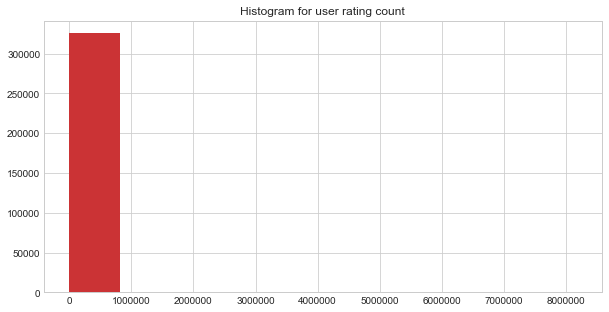

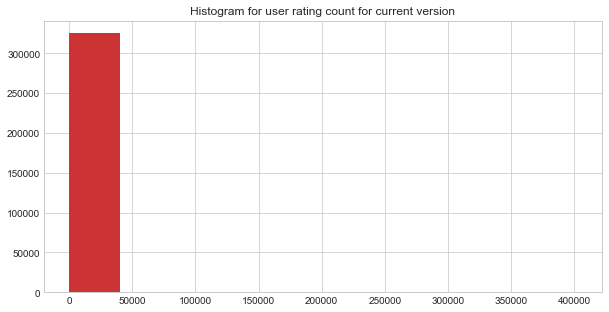

In [48]:
data['userRatingCount'] = df.userRatingCount.replace('null', 0)
data.userRatingCount = data.userRatingCount.apply(lambda x: int(x))
data.userRatingCount.hist(figsize=(10, 5))
plt.title("Histogram for user rating count")

plt.figure()
data['userRatingCountCV'] = df.userRatingCountCV.replace('null', 0)
data.userRatingCountCV = data.userRatingCountCV.apply(lambda x: int(x))
data.userRatingCountCV.hist(figsize=(10, 5))
plt.title("Histogram for user rating count for current version")

### (25) sellerUrl
 - Not all of the sellers have url, so one interesting property would be to check if website exist on the first place

In [49]:
data['hasUrl'] = df.sellerUrl.apply(lambda x: x != 'null')

print ("% apps with and without seller url")
print (data.hasUrl.value_counts(normalize=True) * 100)

data['hasUrl'].head(10)

% apps with and without seller url
False    54.957502
True     45.042498
Name: hasUrl, dtype: float64


0    False
1     True
2    False
3    False
4     True
5    False
6    False
7    False
8     True
9    False
Name: hasUrl, dtype: bool

In [50]:
def getDomain(url):
    if url == 'null':
        return 'null'
    
    _splt = url.split('/')
    if len(_splt) >= 3:
        return _splt[2]
    return 'null'

data['sellerUrl'] = df.sellerUrl
data['sellerUrlDomain'] = df.sellerUrl.apply(lambda x: getDomain(x))

In [51]:
data.head(10)

,bundleId,trackName,IsUniversal,advisories,fileSizeInMB,contentAdvisoryRating,currentVersionReleaseDate,version,subversion,artist,...,releaseDate,ageInDays,minimumOsVersion,averageUserRating,avgUserRatingCV,userRatingCount,userRatingCountCV,hasUrl,sellerUrl,sellerUrlDomain
0,com.aaa.iphone.discounts,AAA Mobile,True,[],153.721680,4+,2017-12-19T13:23:36Z,3,3.11,American Automobile Association,...,2009-04-21T04:39:36Z,3189,10,3.0,3.0,24767,34,False,null,null
1,com.nextgenreality.gunclublite,AAA GUN CLUB lite,False,"[""Infrequent/Mild Mature/Suggestive Themes""]",29.033732,9+,2009-11-07T02:12:31Z,1,1.7,Gun Club Studios,...,2009-04-28T07:00:00Z,3182,2,3.5,3.5,30957,20294,True,http://www.thebinarymill.com/gunclub3/,www.thebinarymill.com
2,com.mcgames.chaosstrike2,Vanguard Online - AAA Shooting Free Online Gam...,True,"[""Infrequent/Mild Realistic Violence"", ""Infreq...",174.367188,12+,2016-06-13T17:52:01Z,2,2.0,Hasim Mert Corekci,...,2016-01-30T00:15:05Z,715,7,4.0,4.0,403,259,False,null,null
3,com.BulletParty.BunboGames,AAA Bullet Party - Online first person shooter...,True,"[""Frequent/Intense Mature/Suggestive Themes"", ...",1182.394531,17+,2015-04-22T15:01:15Z,1,1.0,Engin Yildiz,...,2014-11-06T01:21:25Z,1164,6,3.5,3.5,165,146,False,null,null
4,com.fmapp2010.ISearchFree,iSheacher,False,"[""Infrequent/Mild Alcohol, Tobacco, or Drug Us...",1.434688,17+,2011-11-23T01:52:45Z,1,1.3,feng min,...,2010-05-19T07:00:00Z,2796,3,2.5,2.0,322,71,True,http://clotapp.blog.com/2010/04/19/all-images-...,clotapp.blog.com
5,com.onteca.civilwarlite,AAA American Civil War Cannon Shooter : Defend...,True,"[""Infrequent/Mild Cartoon or Fantasy Violence""]",107.042969,9+,2015-06-29T16:38:41Z,4,4.1,Onteca,...,2012-11-16T20:26:43Z,1884,6,3.0,3.5,199,50,False,null,null
6,com.appynation.powertoolsfree,Draw with Powertools FX Free,True,[],56.867188,4+,2016-01-12T23:42:31Z,2,2.7,Onteca,...,2012-08-02T19:17:30Z,1990,7,4.0,2.5,64,4,False,null,null
7,com.1361447304.4691361447304,AAA+ Foundr - Entrepreneur Magazine for a Startup,True,[],32.477539,4+,2017-05-12T22:18:51Z,7,7.8,NHC PUBLISHING PTY. LTD,...,2013-03-05T00:19:42Z,1776,8,5.0,5.0,325,5,False,null,null
8,com.1443792976.11461443792976,AAA+ Swimsuits & Sports Magazine App For Men,True,"[""Infrequent/Mild Mature/Suggestive Themes"", ""...",37.444336,17+,2017-02-14T21:57:51Z,7,7.8,azacreations,...,2015-10-13T20:10:31Z,823,8,4.0,3.5,86,17,True,http://www.swimsuitsandsports.com/,www.swimsuitsandsports.com
9,com.AnjaneyaApps.AAA1024Free,AAA 1024 Puzzle - cool math board game,True,[],13.113281,4+,2014-05-28T07:00:00Z,1,1.2,Bharat Bhushan,...,2014-05-28T07:00:00Z,1326,6,4.5,4.5,7,7,False,null,null


### (26) releaseNotes

In [52]:
data['releaseNotes'] = df.releaseNotes

## Write new data frame to disk

In [58]:
data.to_csv("../dataset/processed.data.csv", encoding='utf-8', index=False)

### Let's have a look at summary so far for paid apps

In [54]:
paidApps = df[df.price > 0]
paidApps.shape

(34372, 30)

**Summary**: around 15.5K paid apps have been mined; Let's look at their `contentAdvisoryRating` and `Genres`

In [55]:
def plotSummary(_df, figsize=(10, 5)):
    print (_df.contentAdvisoryRating.value_counts())
    print ()
    print ("Normalized distribution in %")
    print (_df.contentAdvisoryRating.value_counts(normalize =True) * 100)

    _ct = pd.crosstab(_df.contentAdvisoryRating, "count")
    _ct.plot(kind="pie", subplots=True)
    _ct.plot(kind="bar")
    plt.title("Distribution by content advisory rating")    
    
    # Genres
    _genres = {}
    for genreString in _df.genres.values:
        gs = json.loads(genreString)
        for g in gs:
            if g not in _genres:
                _genres[g] = 0
            _genres[g] = _genres[g] + 1
    
    _gdf = pd.DataFrame([[k,v] for k,v in _genres.items()], columns=['genre', 'count'])
    _gs = _gdf.sort_values(["count"], axis=0, ascending=False)
    
    plt.figure(figsize=figsize)
    fx = sns.barplot(x='genre', y='count', data=_gs.head(30))
    fx.set_xticklabels(rotation=90, labels=_gs['genre'])
    plt.title("Distribution by genres")
    
    _ct = pd.crosstab(_df.primaryGenreName, "count")
    print (_ct.columns)
    _ct = _ct.sort_values(["count"], axis=0, ascending=False)
#     sns.barplot(x='primaryGenreName', y='count', data=_ct)
    _ct.plot(kind='bar', figsize=figsize)
    plt.title("Distribution by primary genres")


4+     27707
12+     2856
17+     2261
9+      1548
Name: contentAdvisoryRating, dtype: int64

Normalized distribution in %
4+     80.609217
12+     8.309089
17+     6.578029
9+      4.503666
Name: contentAdvisoryRating, dtype: float64
Index(['count'], dtype='object', name='col_0')


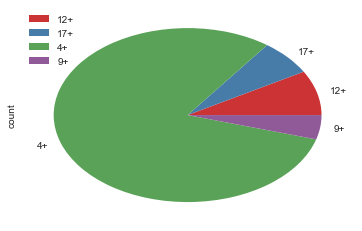

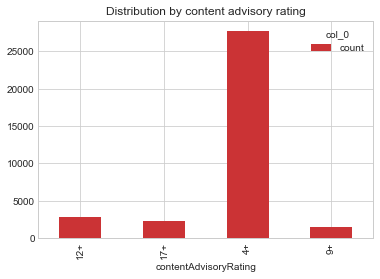

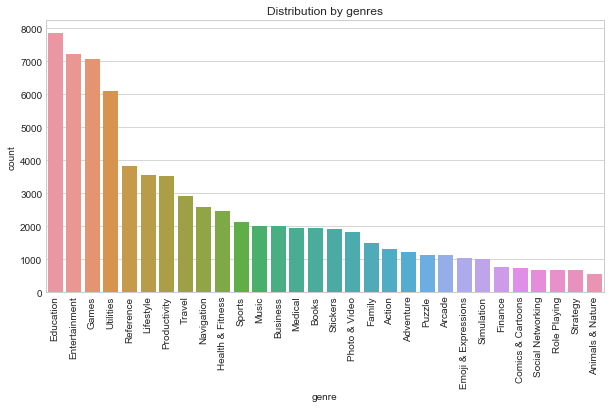

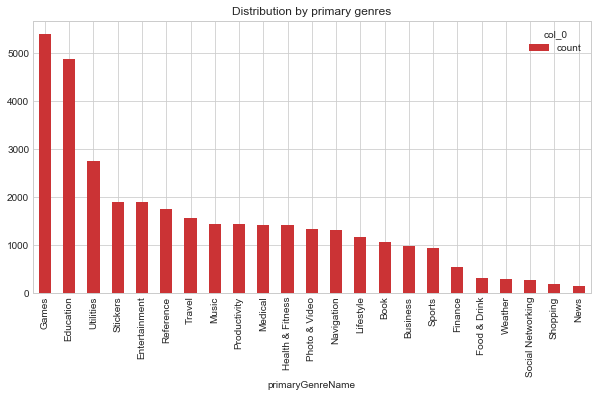

In [56]:
plotSummary(paidApps)

**Summary**:
 - Paid apps are more educational as compared to Games or Entertainment
 - Content Advisory Rating seem to be similar to free apps